In [3]:
from datasets import load_dataset, concatenate_datasets, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import evaluate
from huggingface_hub import notebook_login

/home/jw/anaconda3/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-01 17:05:19.010448: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 17:05:19.010471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 17:05:19.012127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 17:05:19.163452: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow 

In [4]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=2).to("cuda")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
tum_dataset = load_dataset("yangezheng/tum-nlp-sexism-socialmedia-balanced")
lidia_dataset = load_dataset("yangezheng/lidiapierre-fr_sexism_labelled")
cmsb_dataset = load_dataset("yangezheng/CMSB")
swsr_comment_dataset = load_dataset("yangezheng/SWSR-SexComment")
swsr_weibo_dataset = load_dataset("yangezheng/SWSR-SexWeibo")
exist_dataset = load_dataset("yangezheng/EXIST2021")

Using custom data configuration yangezheng--tum-nlp-sexism-socialmedia-balanced-5f6a67b6df4f5ff5
Found cached dataset parquet (/home/jw/.cache/huggingface/datasets/yangezheng___parquet/yangezheng--tum-nlp-sexism-socialmedia-balanced-5f6a67b6df4f5ff5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 3/3 [00:00<00:00, 168.03it/s]
Using custom data configuration yangezheng--lidiapierre-fr_sexism_labelled-47db41fd986d0b6f
Found cached dataset parquet (/home/jw/.cache/huggingface/datasets/yangezheng___parquet/yangezheng--lidiapierre-fr_sexism_labelled-47db41fd986d0b6f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 3/3 [00:00<00:00, 746.10it/s]
Using custom data configuration yangezheng--CMSB-e8830d4b5003421a
Found cached dataset parquet (/home/jw/.cache/huggingface/datasets/yangezheng___parquet/yangezheng--CMSB-e8830d4b5003421a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|███████

In [6]:
lidia_dataset = lidia_dataset.remove_columns("fr_sentences")
cmsb_dataset = cmsb_dataset.remove_columns("toxicity")
swsr_comment_dataset = swsr_comment_dataset.remove_columns("text_cn")
swsr_comment_dataset = swsr_comment_dataset.remove_columns("category")
swsr_comment_dataset = swsr_comment_dataset.remove_columns("target")
swsr_weibo_dataset = swsr_weibo_dataset.remove_columns("text_cn")
swsr_weibo_dataset = swsr_weibo_dataset.remove_columns("keyword")
exist_dataset = exist_dataset.remove_columns("text_original")
exist_dataset = exist_dataset.remove_columns("task2")

In [7]:
train_dataset = concatenate_datasets([tum_dataset["train"], lidia_dataset["train"], cmsb_dataset["train"], swsr_comment_dataset["train"], swsr_weibo_dataset["train"], exist_dataset["train"]])
train_dataset

Dataset({
    features: ['text', 'label_sexist'],
    num_rows: 41335
})

In [8]:
validation_dataset = concatenate_datasets([tum_dataset["validation"], lidia_dataset["validation"], cmsb_dataset["validation"], swsr_comment_dataset["validation"], swsr_weibo_dataset["validation"], exist_dataset["validation"]])
validation_dataset

Dataset({
    features: ['text', 'label_sexist'],
    num_rows: 5368
})

In [9]:
test_dataset = concatenate_datasets([tum_dataset["test"], lidia_dataset["test"], cmsb_dataset["test"], swsr_comment_dataset["test"], swsr_weibo_dataset["test"], exist_dataset["test"]])
test_dataset

Dataset({
    features: ['text', 'label_sexist'],
    num_rows: 8730
})

In [10]:
def preprocess(examples):
    dataset = examples.to_pandas()
    dataset = dataset.dropna()
    # filter out sentences with more than 4 sentences
    dataset = dataset[dataset['text'].apply(lambda x: len(x.split('.'))) <= 4]
    # filter out sentences with more than 100 words
    dataset = dataset[dataset['text'].apply(lambda x: len(x.split())) <= 100]
    return dataset

In [11]:
train = train_dataset.to_pandas()
train = train.dropna()
validation = validation_dataset.to_pandas()
validation = validation.dropna()
test = test_dataset.to_pandas()
test = test.dropna()

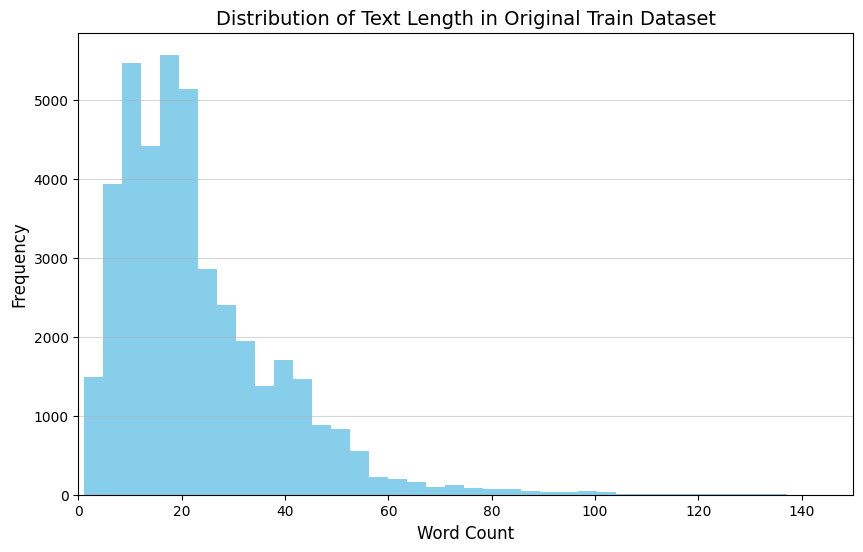

In [12]:
import matplotlib.pyplot as plt

# Calculate the length of each text in the train dataset
train['text_length'] = train['text'].apply(lambda x: len(x.split()))

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(train['text_length'], bins=150, color='skyblue')

# Add grid lines
plt.grid(axis='y', alpha=0.5)

# Set the x-axis and y-axis labels
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Set the title and font size
plt.title('Distribution of Text Length in Original Train Dataset', fontsize=14)

# Set the x-axis limit
plt.xlim(0, 150)

# Show the plot
plt.show()


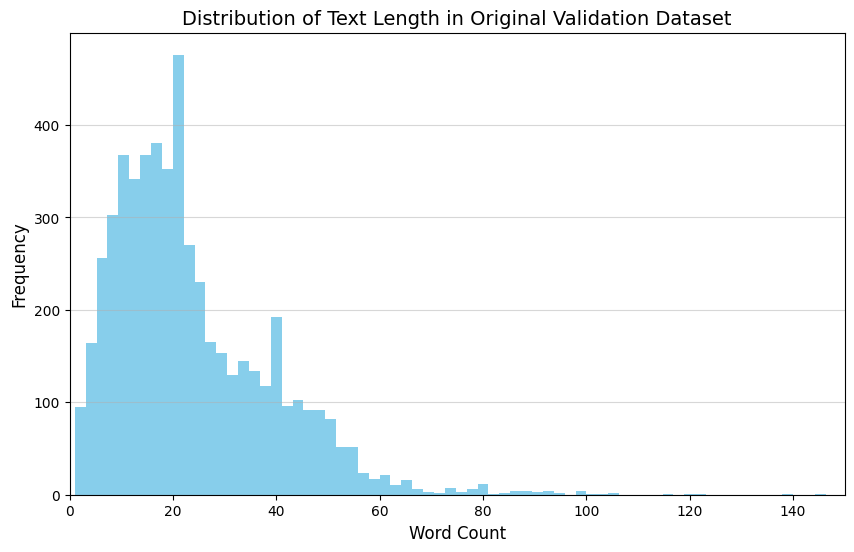

In [13]:
validation['text_length'] = validation['text'].apply(lambda x: len(x.split()))

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(validation['text_length'], bins=150, color='skyblue')

# Add grid lines
plt.grid(axis='y', alpha=0.5)

# Set the x-axis and y-axis labels
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Set the title and font size
plt.title('Distribution of Text Length in Original Validation Dataset', fontsize=14)

# Set the x-axis limit
plt.xlim(0, 150)

# Show the plot
plt.show()


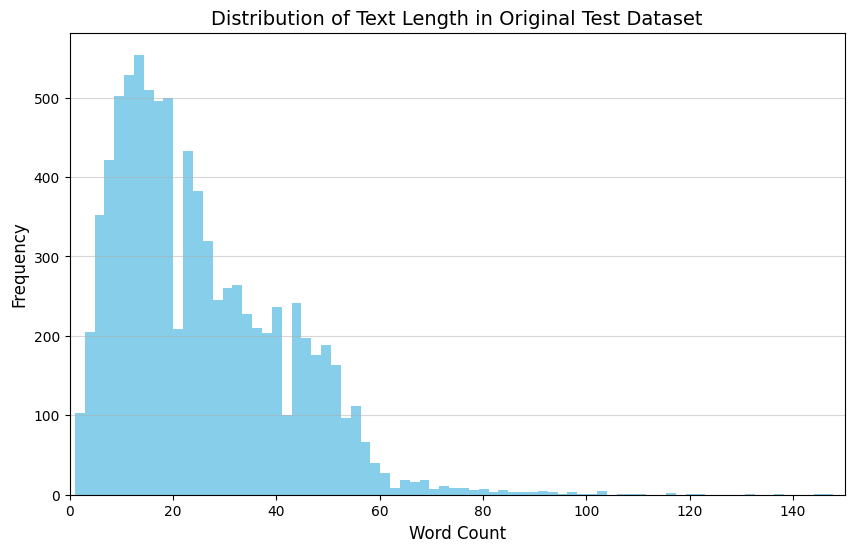

In [14]:
test['text_length'] = test['text'].apply(lambda x: len(x.split()))

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(test['text_length'], bins=150, color='skyblue')

# Add grid lines
plt.grid(axis='y', alpha=0.5)

# Set the x-axis and y-axis labels
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Set the title and font size
plt.title('Distribution of Text Length in Original Test Dataset', fontsize=14)

# Set the x-axis limit
plt.xlim(0, 150)

# Show the plot
plt.show()

In [15]:
processed_train = preprocess(train_dataset)
processed_validation = preprocess(validation_dataset)
processed_test = preprocess(test_dataset)

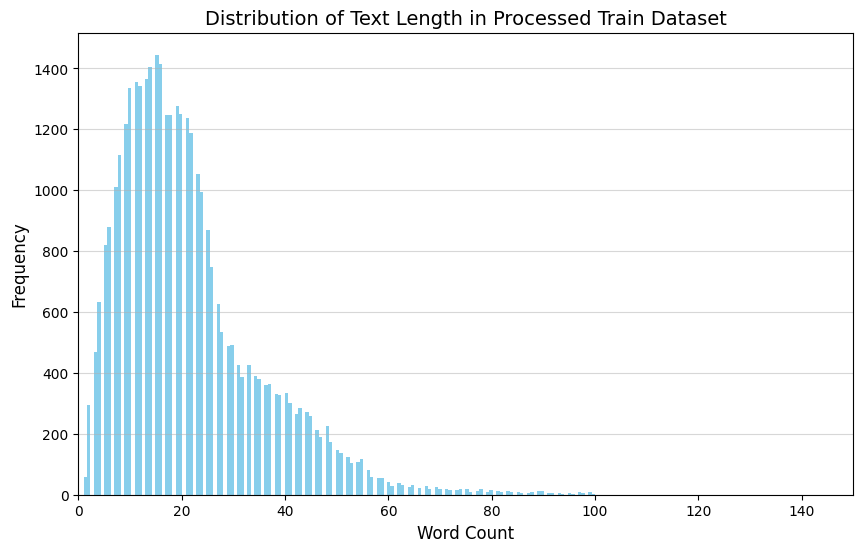

In [16]:
import matplotlib.pyplot as plt

# Calculate the length of each text in the train dataset
processed_train['text_length'] = processed_train['text'].apply(lambda x: len(x.split()))

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(processed_train['text_length'], bins=150, color='skyblue')

# Add grid lines
plt.grid(axis='y', alpha=0.5)

# Set the x-axis and y-axis labels
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Set the title and font size
plt.title('Distribution of Text Length in Processed Train Dataset', fontsize=14)

# Set the x-axis limit
plt.xlim(0, 150)

# Show the plot
plt.show()

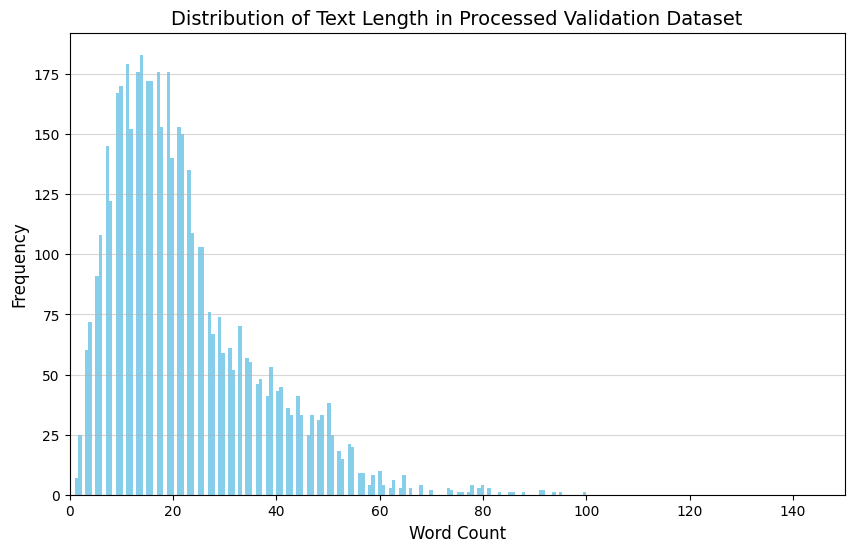

In [17]:
processed_validation['text_length'] = processed_validation['text'].apply(lambda x: len(x.split()))

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(processed_validation['text_length'], bins=150, color='skyblue')

# Add grid lines
plt.grid(axis='y', alpha=0.5)

# Set the x-axis and y-axis labels
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Set the title and font size
plt.title('Distribution of Text Length in Processed Validation Dataset', fontsize=14)

# Set the x-axis limit
plt.xlim(0, 150)

# Show the plot
plt.show()

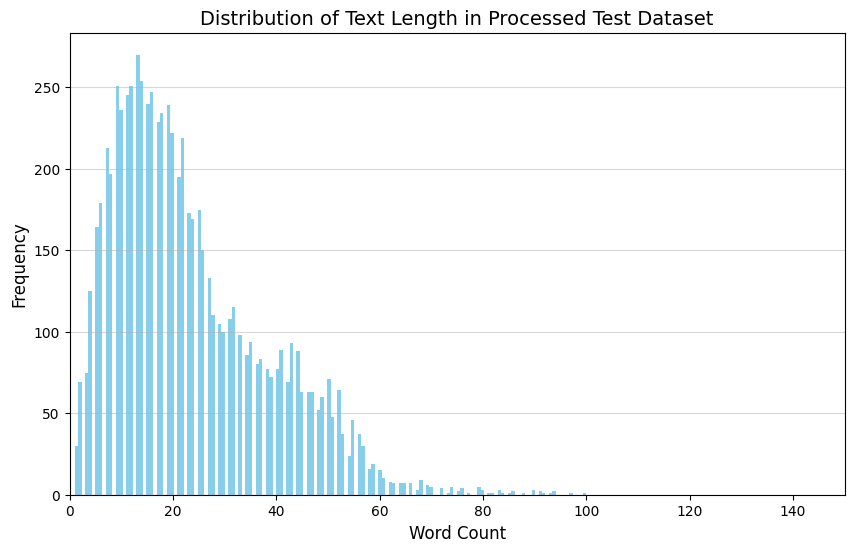

In [18]:
processed_test['text_length'] = processed_test['text'].apply(lambda x: len(x.split()))

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(processed_test['text_length'], bins=150, color='skyblue')

# Add grid lines
plt.grid(axis='y', alpha=0.5)

# Set the x-axis and y-axis labels
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Set the title and font size
plt.title('Distribution of Text Length in Processed Test Dataset', fontsize=14)

# Set the x-axis limit
plt.xlim(0, 150)

# Show the plot
plt.show()

In [30]:
# Calculate the label distribution
label_counts = train['label_sexist'].value_counts()

# Calculate the percentage of each label
label_percentages = label_counts / len(train) * 100

# Print the label distribution and percentage
print("Label Distribution of Train before processing:")
print(label_counts)
print("\nLabel Percentage:")
print(label_percentages)

# Calculate the label distribution
label_counts = validation['label_sexist'].value_counts()

# Calculate the percentage of each label
label_percentages = label_counts / len(validation) * 100

# Print the label distribution and percentage
print("\nLabel Distribution of Validation before processing:")
print(label_counts)
print("\nLabel Percentage:")
print(label_percentages)

# Calculate the label distribution
label_counts = test['label_sexist'].value_counts()

# Calculate the percentage of each label
label_percentages = label_counts / len(test) * 100

# Print the label distribution and percentage
print("\nLabel Distribution of Test before processing:")
print(label_counts)
print("\nLabel Percentage:")
print(label_percentages)


Label Distribution of Train before processing:
label_sexist
0    26138
1    15195
Name: count, dtype: int64

Label Percentage:
label_sexist
0    63.237607
1    36.762393
Name: count, dtype: float64

Label Distribution of Validation before processing:
label_sexist
0    3304
1    2064
Name: count, dtype: int64

Label Percentage:
label_sexist
0    61.549925
1    38.450075
Name: count, dtype: float64

Label Distribution of Test before processing:
label_sexist
0    4931
1    3799
Name: count, dtype: int64

Label Percentage:
label_sexist
0    56.483391
1    43.516609
Name: count, dtype: float64


In [31]:
# Calculate the label distribution
label_counts = processed_train['label_sexist'].value_counts()

# Calculate the percentage of each label
label_percentages = label_counts / len(processed_train) * 100

# Print the label distribution and percentage
print("Label Distribution of Train after processing:")
print(label_counts)
print("\nLabel Percentage:")
print(label_percentages)

# Calculate the label distribution
label_counts = processed_validation['label_sexist'].value_counts()

# Calculate the percentage of each label
label_percentages = label_counts / len(processed_validation) * 100

# Print the label distribution and percentage
print("\nLabel Distribution of Validation after processing:")
print(label_counts)
print("\nLabel Percentage:")
print(label_percentages)

# Calculate the label distribution
label_counts = processed_test['label_sexist'].value_counts()

# Calculate the percentage of each label
label_percentages = label_counts / len(processed_test) * 100

# Print the label distribution and percentage
print("\nLabel Distribution of Test after processing:")
print(label_counts)
print("\nLabel Percentage:")
print(label_percentages)




Label Distribution of Train after processing:
label_sexist
0    23361
1    13561
Name: count, dtype: int64

Label Percentage:
label_sexist
0    63.27122
1    36.72878
Name: count, dtype: float64

Label Distribution of Validation after processing:
label_sexist
0    2910
1    1844
Name: count, dtype: int64

Label Percentage:
label_sexist
0    61.211611
1    38.788389
Name: count, dtype: float64

Label Distribution of Test after processing:
label_sexist
0    4299
1    3252
Name: count, dtype: int64

Label Percentage:
label_sexist
0    56.932857
1    43.067143
Name: count, dtype: float64
